# RTS vs BIFM Smoothing

## Import packages

In [1]:
using Pkg
Pkg.activate("..")

using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

 Activating environment at `c:\Users\s151781\Desktop\ReactiveMP.jl\Project.toml`
┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\s151781\.julia\packages\Revise\1boD5\src\packagedef.jl:1369
┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278


## Data generation

In [52]:
function generate_parameters(dim_out::Int64, dim_in::Int64, dim_lat::Int64; seed::Int64 = 123)
    
    # define noise levels
    input_noise  = 500.0
    output_noise = 50.0

    # create random generator for reproducibility
    rng = MersenneTwister(seed)

    # generate matrices, input statistics and noise matrices
    A      = diagm(0.8 .* ones(dim_lat) .+ 0.2 * rand(rng, dim_lat))                                            # size (dim_lat x dim_lat)
    B      = rand(dim_lat, dim_in)                                                                              # size (dim_lat x dim_in)
    C      = rand(dim_out, dim_lat)                                                                             # size (dim_out x dim_lat)
    μu     = rand(dim_in) .* collect(1:dim_in)                                                                  # size (dim_in x 1)
    Σu     = input_noise  .* collect(Hermitian(randn(rng, dim_in, dim_in) + diagm(10 .+ 10*rand(dim_in))))      # size (dim_in x dim_in)
    Σx     = output_noise .* collect(Hermitian(randn(rng, dim_out, dim_out) + diagm(10 .+ 10*rand(dim_out))))   # size (dim_out x dim_out)
    Wu     = cholinv(Σu)
    Wx     = cholinv(Σx)
    
    # return parameters
    return A, B, C, μu, Σu, Σx, Wu, Wx

end;

In [53]:
function generate_data(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Σu::Array{Float64,2}, Σx::Array{Float64,2}; seed::Int64 = 123)
        
    # create random data generator
    rng = MersenneTwister(seed)
    
    # preallocate space for variables
    z = Vector{Vector{Float64}}(undef, nr_samples)
    x = Vector{Vector{Float64}}(undef, nr_samples)
    u = rand(rng, MvNormal(μu, Σu), nr_samples)'
    
    # set initial value of latent states
    z_prev = zeros(size(A,1))
    
    # generate data
    for i in 1:nr_samples

        # generate new latent state
        z[i] = A * z_prev + B * u[i,:]

        # generate new observation
        x[i] = C * z[i] + rand(rng, MvNormal(zeros(dim_out), Σx))
        
        # generate new observation
        z_prev .= z[i]
        
    end
    
    # return generated data
    return z, x, u
    
end;

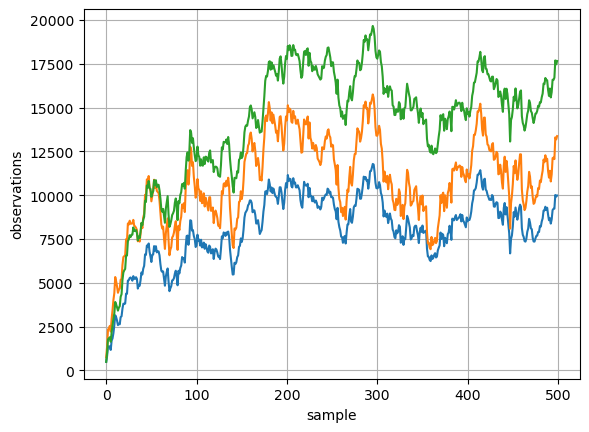

In [54]:
# specify settings
nr_samples = 500
dim_out = 3
dim_in = 45
dim_lat = 3

# generate parameters
A, B, C, μu, Σu, Σx, Wu, Wx = generate_parameters(dim_out, dim_in, dim_lat);
            
# generate data
data_z, data_x, data_u = generate_data(nr_samples, A, B, C, μu, Σu, Σx);

# visualise data
plt.plot(data_x)
plt.grid()
plt.xlabel("sample")
plt.ylabel("observations");

## Model specification

In [55]:
@model function RTS_smoother(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wx::Array{Float64,2})
    
    # fetch dimensionality
    dim_lat = size(A, 1)
    dim_out = size(C, 1)
    
    # initialize variables
    z = randomvar(nr_samples)                 # hidden states (random variable)
    u = randomvar(nr_samples)                 # inputs (random variable)
    x = datavar(Vector{Float64}, nr_samples)  # outputs (observed variables)
    
    # set initial hidden state
    z_prior ~ MvNormalMeanPrecision(zeros(dim_lat), 1e-5*diagm(ones(dim_lat)))
    
    # update last/previous hidden state
    z_prev = z_prior

    # loop through observations
    for i in 1:nr_samples

        # specify input as random variable
        u[i] ~ MvNormalMeanPrecision(μu, Wu)
        
        # specify updated hidden state
        z[i] ~ A * z_prev + B * u[i]
        
        # specify observation
        x[i] ~ MvNormalMeanPrecision(C * z[i], Wx)
        
        # update last/previous hidden state
        z_prev = z[i]

    end
    
    # return parameters of interest
    return z, x, u
    
end;

In [56]:
@model function BIFM_smoother(nr_samples::Int64, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wx::Array{Float64,2})

    # fetch dimensionality
    dim_lat = size(A, 1)
    
    # initialize variables
    z  = randomvar(nr_samples)                  # latent states
    xt = randomvar(nr_samples)                  # latent observations
    x  = datavar(Vector{Float64}, nr_samples)   # actual observations
    u  = randomvar(nr_samples)                  # inputs
    
    # set priors
    z_prior ~ MvNormalMeanPrecision(zeros(dim_lat), 1e-5*diagm(ones(dim_lat)))
    z_tmp   ~ BIFM_helper(z_prior) where { q = MeanField()}
    
    # update last/previous hidden state
    z_prev = z_tmp
    
    # loop through observations
    for i in 1:nr_samples

        # specify input as random variable
        u[i]   ~ MvNormalMeanPrecision(μu, Wu)

        # specify observation
        xt[i]  ~ BIFM(u[i], z_prev, z[i]) where { meta = BIFMMeta(A, B, C) }
        x[i]   ~ MvNormalMeanPrecision(xt[i], Wx)
        
        # update last/previous hidden state
        z_prev = z[i]

    end
    
    # set final value
    z[nr_samples] ~ MvNormalMeanPrecision(zeros(dim_lat), zeros(dim_lat, dim_lat))
    
    # return parameters of interest
    return z, x, u
    
end;

## Probabilistic inference

In [57]:
function inference_RTS(data_x::Array{Array{Float64,1},1}, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Σu::Array{Float64,2}, Σx::Array{Float64,2})
    
    # define model
    model, (z, x, u) = RTS_smoother(nr_samples, A, B, C, μu, Σu, Σx)
    
    # initialize buffer for latent states
    zbuffer          = buffer(Marginal, nr_samples)
    
    # subscribe to z
    zsubscription    = subscribe!(getmarginals(z), zbuffer)

    # update x according to observations (i.e. perform inference)
    update!(x, data_x)
    
    # unsubscribe
    unsubscribe!(zsubscription)
    
    # return the marginal values
    return getvalues(zbuffer)

end;

In [58]:
function inference_BIFM(data_x::Array{Array{Float64,1},1}, A::Array{Float64,2}, B::Array{Float64,2}, C::Array{Float64,2}, μu::Array{Float64,1}, Wu::Array{Float64,2}, Wx::Array{Float64,2})  

    # define model
    model, (z, x, u) = BIFM_smoother(nr_samples, A, B, C, μu, Wu, Wx)
    
    # initialize buffer for latent states
    zbuffer          = buffer(Marginal, nr_samples)
    
    # subscribe to z
    zsubscription    = subscribe!(getmarginals(z), zbuffer)
    
    # update x according to observations
    update!(x, data_x)
    
    # when done, unsubscribe
    unsubscribe!(zsubscription)
    
    # return the marginal values
    return getvalues(zbuffer)

end;

## Experiments for 500 observations

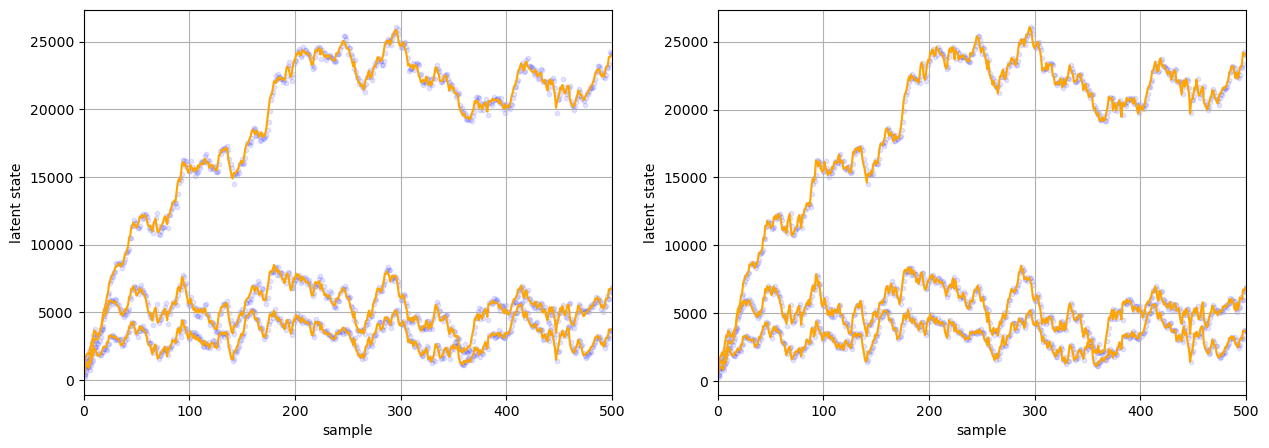

In [59]:
z_RTS = inference_RTS(data_x, A, B, C, μu, Σu, Σx)
z_BIFM = inference_BIFM(data_x, A, B, C, μu, Wu, Wx)
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].plot(mean.(z_RTS), c="orange")
ax[1].scatter(repeat(1:nr_samples, 1, dim_lat)', hcat(data_z...), c="blue", s=10, alpha=0.1)
ax[2].plot(mean.(z_BIFM), c="orange")
ax[2].scatter(repeat(1:nr_samples, 1, dim_lat)', hcat(data_z...), c="blue", s=10, alpha=0.1)
ax[1].grid(), ax[2].grid()
ax[1].set_xlabel("sample"), ax[2].set_xlabel("sample")
ax[1].set_ylabel("latent state"), ax[2].set_ylabel("latent state")
ax[1].set_xlim(0, nr_samples), ax[2].set_xlim(0, nr_samples);

In [60]:
@benchmark inference_RTS(data_x, A, B, C, μu, Σu, Σx)

BenchmarkTools.Trial: 
  memory estimate:  69.91 MiB
  allocs estimate:  626909
  --------------
  minimum time:     670.272 ms (2.24% GC)
  median time:      692.791 ms (2.42% GC)
  mean time:        695.528 ms (2.84% GC)
  maximum time:     735.898 ms (3.18% GC)
  --------------
  samples:          8
  evals/sample:     1

In [61]:
@benchmark inference_BIFM(data_x, A, B, C, μu, Wu, Wx)

BenchmarkTools.Trial: 
  memory estimate:  74.90 MiB
  allocs estimate:  376570
  --------------
  minimum time:     621.661 ms (1.80% GC)
  median time:      634.679 ms (2.47% GC)
  mean time:        640.562 ms (2.73% GC)
  maximum time:     689.250 ms (3.00% GC)
  --------------
  samples:          8
  evals/sample:     1

In [62]:
@benchmark inference_BIFM(data_x, A, B, C, μu, Wu, Wx)

BenchmarkTools.Trial: 
  memory estimate:  74.90 MiB
  allocs estimate:  376570
  --------------
  minimum time:     626.947 ms (2.59% GC)
  median time:      632.274 ms (2.49% GC)
  mean time:        636.147 ms (2.70% GC)
  maximum time:     658.762 ms (3.91% GC)
  --------------
  samples:          8
  evals/sample:     1

In [ ]:
# 632.274 ms -- 74.90 MiB -- 376570